# Tracking Engagement on PA Site

## Part I: Who is using the PA site?

While looking at the data we have around the PA site, I noticed that our numbers seemed to be low. I asked Matt Talese to walk me through the sign-up flow, and we found some unexpected path issues in current state, which I've outlined below. These have been reported to dev and are being fixed, but worth mentioning because they impact the data we have available. 

Based on the observed paths, this analysis consists (mostly) of:
* Any professionals who signed up as PA or students who signed up with a PA school on the regular OME site and subsequently knows to log in directly to the PA site (as opposed to the main site)
* Anyone who signed up on the PA site directly

Note if even if you signed up as a PA (on either site), if you go to the main OME site (from, say, a saved link), you are *not* redirected to the PA site. Again, this is being fixed, but worth mentioning.


<img src="pa_workflow.png">

Another note: we currently don't have any way of tracking who is seeing which site in the database. I've met with Ivan, Patrick, and Anders, and we agreed to add this when we add Segment. 

## Data Steps

In [1]:
library(RMariaDB)
library(DBI)
library(tidyverse)
library(repr)
library(scales)

source('pw.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



In [2]:
ds_prod_con <- dbConnect(RMariaDB::MariaDB(), 
                 dbname = "production",
                 host = 'ome-prod-cluster.cluster-ro-cknesi80kqlo.us-west-2.rds.amazonaws.com',
                 username = prod_username,
                 password = prod_password)

ds_billing_con <- dbConnect(RMariaDB::MariaDB(), 
                 dbname = "billing",
                 host = 'billing-api-cluster.cluster-ro-cknesi80kqlo.us-west-2.rds.amazonaws.com',
                 username = billing_username,
                 password = billing_password)

In [3]:
activity_query <- "select pa.*, c.initial_create from
-- this section figures out who is a PA user + grabs all metrics
(select *
from user_metrics
where user_id in
(select user_id
from user_metrics 
where type = 'new_pa')) as pa
left join
-- this section gets the date each user was created
(select user_id, created_at as initial_create
from user_metrics
where type = 'new_pa') as c
on (pa.user_id = c.user_id)
-- this section is filtering out OME accounts
where pa.user_id not in 
(select users.id
from users
left join role_user ON role_user.`user_id` = users.id
left join roles ON roles.id = role_user.role_id
where roles.id in (1,2,3,4,7,8,9)
or email like '%mailinator.com%'
or email like '%test.com%'
or email like '%+%')"

billing_query <- "select cast(c.client_customer_id as character) as user_id,
 s.plan_id as plan, s.status as sub_status, 
s.start_date as sub_start_date, s.end_date as sub_end_date, s.cancel_date as sub_cancel_date
from subscriptions s
left join customers c
on s.customer_id = c.id
where s.service = 'recurly'
and s.start_date >  '2018-04-07'
and s.status != 'pending'"

customers_query <- "select cast(u.id as character) as user_id, u.first_name, u.last_name,
s.nickname, s.degree, r.name
from users u
left join schools s
on(u.school_text_id = s.id)
left join role_user ru
on(u.id = ru.user_id)
left join roles r
on(ru.role_id = r.id)
where r.name = 'student' or
r.name = 'professional'"

In [4]:
# i'm going to use activity data as a source of truth 
# because it contains the pa_user_created field

activity_data <- dbGetQuery(ds_prod_con, activity_query)
billing_data <- dbGetQuery(ds_billing_con, billing_query)
customer_data <- dbGetQuery(ds_prod_con, customers_query)

In [5]:
free_metrics <- c("new_pa", "active_day", "video")

In [6]:
# note: sub flag is created action by action (rather than at user level)
full_data <- activity_data %>% 
    mutate(user_id = as.character(user_id)) %>%
    left_join(billing_data) %>% 
    mutate(sub_flag = ifelse(as.Date(created_at) >= as.Date(sub_start_date)
                            & (as.Date(created_at) <= as.Date(sub_end_date) |
                               as.Date(created_at) <= as.Date(sub_cancel_date) |
                               is.na(sub_end_date) | is.na(sub_cancel_date)), 1, 0),
          sub_flag = replace_na(sub_flag, 0),
          date = as.Date(created_at),
          week = strftime(date, format = "%Y-%V"))

full_data

Joining, by = "user_id"


id       user_id object_id is_remediation type      
1     15267175 170786     0      0              new_pa    
2     15295303 170786   105      0              video     
3     15273424 170786  1558      0              active_day
4     15295282 170786  1559      0              active_day
5     15270480 170808     0      0              new_pa    
6     15270568 170808   163      0              video     
7     15270499 170808  1558      0              active_day
8     15717672 174197     0      0              new_pa    
9     22371293 174197    22      0              video     
10    22372031 174197    25      0              video     
11    22372443 174197    26      0              video     
12    22372895 174197    28      0              video     
13    22373270 174197    29      0              video     
14    22407078 174197    33      0              video     
15    22368581 174197    41      0              video     
16    22369013 174197    42      0              video     
17    22407637 174197    74      0              video     
18    22408993 174197    75      0              video     
19    22410555 174197    76      0              video     
20    22409305 174197    77      0              video     
21    22409645 174197    78      0              video     
22    22411291 174197    79      0              video     
23    22409947 174197    80      0              video     
24    22411699 174197    82      0              video     
25    22368563 174197  1774      0              active_day
26    22407065 174197  1775      0              active_day
27    15718519 174204     0      0              new_pa    
28    15718650 174204    89      0              video     
29    15718622 174204  1573      0              active_day
30    15720466 174222     0      0              new_pa    
⋮     ⋮        ⋮       ⋮         ⋮              ⋮         
48518 22338430 231312     0      0              new_pa    
48519 22343981 231312     2      0              video     
48520 22441986 231312    16      0              notes     
48521 22442506 231312    17      0              notes     
48522 22442846 231312    17      0              video     
48523 22343924 231312  1773      0              active_day
48524 22441732 231312  1776      0              active_day
48525 22342123 231340    NA      0              time      
48526 22342067 231340     0      0              new_pa    
48527 22371668 231478    NA      0              time      
48528 22370616 231478     0      0              new_pa    
48529 22383724 231478     3      0              video     
48530 22370647 231478     8      0              video     
48531 22370633 231478  1774      0              active_day
48532 22407928 231646    NA      0              time      
48533 22428125 231646    NA      0              time      
48534 22407763 231646     0      0              new_pa    
48535 22440878 231646   143      0              video     
48536 22407792 231646  1775      0              active_day
48537 22428299 231646  1776      0              active_day
48538 22411838 231671    NA      0              time      
48539 22463262 231671    NA      0              time      
48540 22411732 231671     0      0              new_pa    
48541 22411999 231671   123      0              video     
48542 22411789 231671  1775      0              active_day
48543 22463242 231671  1777      0              active_day
48544 22421720 231711    NA      0              time      
48545 22421694 231711     0      0              new_pa    
48546 22421700 231711  1776      0              active_day
48547 22461855 231918     0      0              new_pa    
      description                      value ip             created_at         
1     A new PA user has been created   0     68.228.96.166  2018-04-08 12:57:38
2     User has watched a video (topic) 0     68.228.96.166  2018-04-09 12:08:24
3     User has been active today       0     68.228.96.166  2018-04-08 16:32:43
4     User has been active t

In [7]:
# there are duplicates due to multiple subscriptions --
# taking max of subscription flag to see if action is in a sub
clean_data <- full_data %>%
    group_by(id, user_id, object_id, is_remediation, type, description, value, 
             ip, date, updated_at, initial_create, week) %>%
    summarise(sub_flag = max(sub_flag), min_sub_start = min(sub_start_date), 
              max_sub_start = max(sub_start_date))

## Part II: What do we know about PA site users?

## How many registered users do we have?

In [8]:
pa_users <- clean_data %>%
filter(type == 'new_pa') %>%
group_by(date) %>%
summarise(n_day = n()) %>%
complete(date = seq.Date(from = min(clean_data$date), to = max(clean_data$date), by = "day")) %>%
mutate(n_day = replace_na(n_day, 0))


pa_users$n_total <- cumsum(pa_users$n_day)

weekly_pa_users <- clean_data %>%
filter(type == 'new_pa') %>%
group_by(week) %>%
summarise(n_week = n())

weekly_pa_users$n_weekly_total <- cumsum(weekly_pa_users$n_week)

In [9]:
write.csv(pa_users, "pa_users.csv")

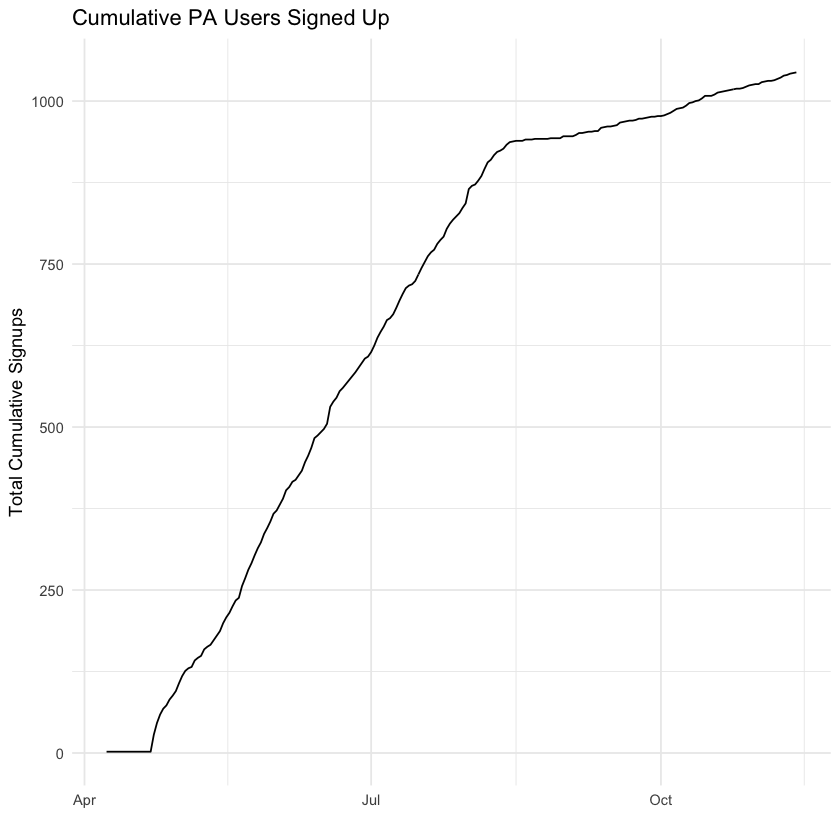

In [10]:
pa_users %>%
ggplot(aes(x = date, y = n_total)) + geom_line() +
ggtitle("Cumulative PA Users Signed Up") + theme_minimal() + ylab("Total Cumulative Signups") + xlab("") 

options(repr.plot.width=7, repr.plot.height=2)

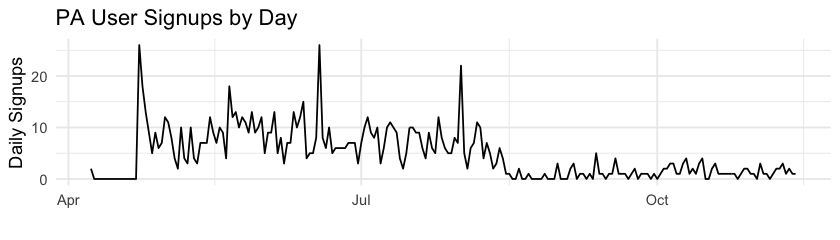

In [11]:
pa_users %>%
ggplot(aes(x = date, y = n_day)) + geom_line() + ggtitle("PA User Signups by Day") + theme_minimal() +
xlab("") + ylab("Daily Signups")

## How many subscribers do we have?

In [12]:
# for each day, check to see if in between on/off dates
# group by subscriber, take max of this flag

subs <- full_data %>%
    group_by(user_id, sub_start_date, sub_end_date, sub_cancel_date) %>%
    filter(is.na(sub_start_date) == FALSE) %>%
    complete(date = seq.Date(from = min(clean_data$date), to = max(clean_data$date), by = "day")) %>%
    mutate(sub_flag = ifelse(date >= sub_start_date & ((date <= sub_end_date | is.na(sub_end_date)) |
                                            date <= sub_cancel_date | is.na(sub_cancel_date)), 1, 0)) %>%
    select(user_id, sub_start_date, sub_end_date, sub_cancel_date, date, sub_flag) %>%
    group_by(date, user_id) %>%
    summarise(sub_flag = max(sub_flag)) %>%
    mutate(week = strftime(date, format = "%Y-%V"))

In [13]:
daily_subs <- subs %>%
    group_by(date) %>%
    summarise(total_subs = sum(sub_flag))

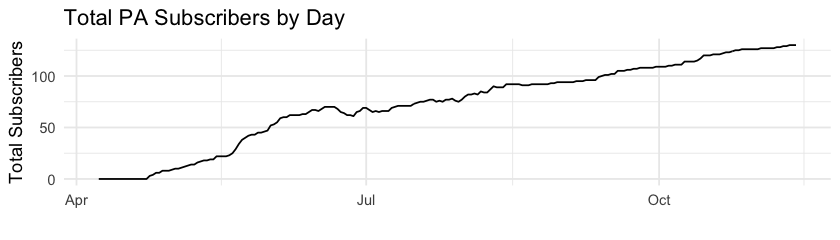

In [14]:
# note : x axis here is set at y = 1
daily_subs %>%
    ggplot(aes(x = date, y = total_subs)) + geom_line() +
    ggtitle("Total PA Subscribers by Day") + theme_minimal() +
    xlab("") + ylab("Total Subscribers")

## TL; DR: Users and Subscribers by Day

In [15]:
daily_subs_users <- daily_subs %>%
    left_join(pa_users) %>%
    mutate(diff = n_total - total_subs) %>%
    gather(total_subs, diff, -date, -n_total, -n_day) %>%
    rename(type = total_subs) %>%
    mutate(type = ifelse(type == "diff", "Registered Users", "Subscribers")) 
    

Joining, by = "date"


In [16]:
tail(daily_subs_users, 2)

date       n_day n_total type             diff
1 2018-11-12 1     1043    Registered Users 913 
2 2018-11-13 1     1044    Registered Users 914

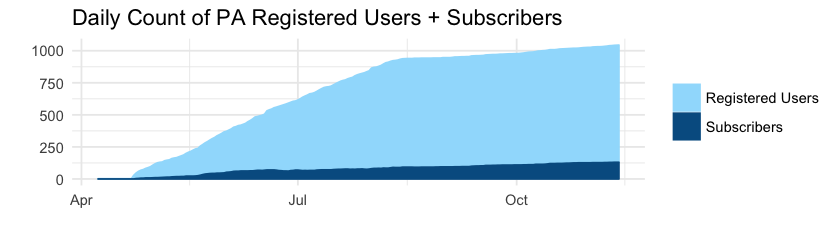

In [17]:
pa_palette <- c("#9FDEFC", "#005D91")

daily_subs_users %>%
    ggplot(aes(x = date, y = diff)) + 
    geom_area(aes(colour = type, fill = type), 
              position = 'stack') + ggtitle("Daily Count of PA Registered Users + Subscribers") +
    theme_minimal() + ylab("") + xlab("") + theme(legend.title=element_blank()) +
    scale_fill_manual(values = pa_palette) + scale_colour_manual(values = pa_palette) +
    theme(legend.spacing.x = unit(.1, 'cm'))

options(repr.plot.width=8, repr.plot.height=4)

## What percent of users are active each day?

In [18]:
daily_users <- clean_data %>%
filter(type == 'active_day') %>%
group_by(date) %>%
summarise(daily_users = n()) %>%
complete(date = seq.Date(from = min(clean_data$date), to = max(clean_data$date), by = "day")) %>%
full_join(pa_users[,c("date", "n_total")]) %>%
fill(n_total) %>%
mutate(daily_users = replace_na(daily_users, 0),
       perc_using_daily = daily_users / n_total)

Joining, by = "date"


In [19]:
daily_users

date       daily_users n_total perc_using_daily
1   2018-04-08  2            2     1.00000000      
2   2018-04-09  1            2     0.50000000      
3   2018-04-10  0            2     0.00000000      
4   2018-04-11  0            2     0.00000000      
5   2018-04-12  0            2     0.00000000      
6   2018-04-13  0            2     0.00000000      
7   2018-04-14  0            2     0.00000000      
8   2018-04-15  0            2     0.00000000      
9   2018-04-16  0            2     0.00000000      
10  2018-04-17  0            2     0.00000000      
11  2018-04-18  0            2     0.00000000      
12  2018-04-19  0            2     0.00000000      
13  2018-04-20  0            2     0.00000000      
14  2018-04-21  0            2     0.00000000      
15  2018-04-22  0            2     0.00000000      
16  2018-04-23 19           28     0.67857143      
17  2018-04-24 19           46     0.41304348      
18  2018-04-25 23           59     0.38983051      
19  2018-04-26 16           68     0.23529412      
20  2018-04-27 15           73     0.20547945      
21  2018-04-28 16           82     0.19512195      
22  2018-04-29 16           88     0.18181818      
23  2018-04-30 21           95     0.22105263      
24  2018-05-01 28          107     0.26168224      
25  2018-05-02 28          118     0.23728814      
26  2018-05-03 21          126     0.16666667      
27  2018-05-04 19          130     0.14615385      
28  2018-05-05 12          132     0.09090909      
29  2018-05-06 23          142     0.16197183      
30  2018-05-07 27          146     0.18493151      
⋮   ⋮          ⋮           ⋮       ⋮               
191 2018-10-15 69          1008    0.06845238      
192 2018-10-16 71          1008    0.07043651      
193 2018-10-17 62          1008    0.06150794      
194 2018-10-18 57          1010    0.05643564      
195 2018-10-19 47          1013    0.04639684      
196 2018-10-20 45          1014    0.04437870      
197 2018-10-21 50          1015    0.04926108      
198 2018-10-22 80          1016    0.07874016      
199 2018-10-23 78          1017    0.07669617      
200 2018-10-24 72          1018    0.07072692      
201 2018-10-25 61          1019    0.05986261      
202 2018-10-26 44          1019    0.04317959      
203 2018-10-27 50          1020    0.04901961      
204 2018-10-28 72          1022    0.07045010      
205 2018-10-29 67          1024    0.06542969      
206 2018-10-30 76          1025    0.07414634      
207 2018-10-31 46          1026    0.04483431      
208 2018-11-01 50          1026    0.04873294      
209 2018-11-02 45          1029    0.04373178      
210 2018-11-03 40          1030    0.03883495      
211 2018-11-04 61          1031    0.05916586      
212 2018-11-05 65          1031    0.06304559      
213 2018-11-06 66          1032    0.06395349      
214 2018-11-07 67          1034    0.06479691      
215 2018-11-08 64          1036    0.06177606      
216 2018-11-09 40          1039    0.03849856      
217 2018-11-10 42          1040    0.04038462      
218 2018-11-11 63          1042    0.06046065      
219 2018-11-12 72          1043    0.06903164      
220 2018-11-13 25          1044    0.02394636

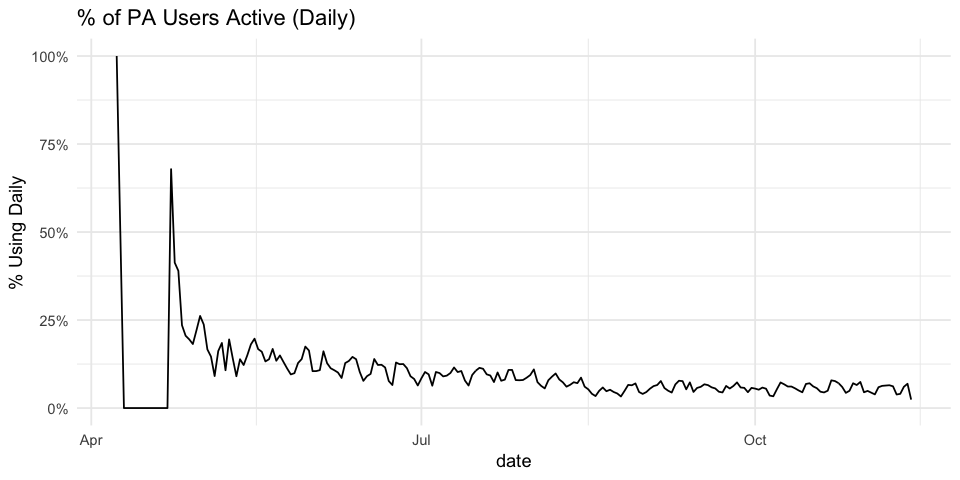

In [20]:
daily_users %>%
ggplot(aes(x = date, y = perc_using_daily)) + geom_line() +
ggtitle("% of PA Users Active (Daily)") + theme_minimal() +
ylab("% Using Daily") + scale_y_continuous(labels = scales::percent)

## What % of users perform each action weekly?

In [21]:
# UNDER CONSTRUCTION !!
tail(clean_data)

id       user_id object_id is_remediation type      
1 22468773 184451  1777      0              active_day
2 22468774 184451   169      0              video     
3 22468901 184451   233      0              video     
4 22469585 194987  1777      0              active_day
5 22469688 193300  1777      0              active_day
6 22469768 193300   111      0              video     
  description                      value ip              date      
1 User has been active today       0     67.187.113.30   2018-11-13
2 User has watched a video (topic) 0     67.187.113.30   2018-11-13
3 User has watched a video (topic) 0     67.187.113.30   2018-11-13
4 User has been active today       0     184.180.127.114 2018-11-13
5 User has been active today       0     149.68.7.120    2018-11-13
6 User has watched a video (topic) 0     149.68.7.120    2018-11-13
  updated_at          initial_create      week    sub_flag min_sub_start
1 2018-11-13 04:00:46 2018-05-31 07:19:57 2018-46 0        <NA>         
2 2018-11-13 04:00:47 2018-05-31 07:19:57 2018-46 0        <NA>         
3 2018-11-13 04:06:11 2018-05-31 07:19:57 2018-46 0        <NA>         
4 2018-11-13 04:33:09 2018-07-02 13:53:08 2018-46 0        <NA>         
5 2018-11-13 04:36:37 2018-06-28 20:13:16 2018-46 0        <NA>         
6 2018-11-13 04:40:08 2018-06-28 20:13:16 2018-46 0        <NA>         
  max_sub_start
1 <NA>         
2 <NA>         
3 <NA>         
4 <NA>         
5 <NA>         
6 <NA>

In [22]:
# let's do this first pretending that everyone is active for all weeks
weekly_user_actions <- clean_data %>%
group_by(week, type) %>%
summarise(n = n(), n_distinct_things = n_distinct(user_id)) %>%
left_join(weekly_pa_users[,c("week", "n_weekly_total")]) %>%
mutate(perc_using = n_distinct_things / n_weekly_total)


head(weekly_user_actions, 5)

Joining, by = "week"


week    type       n n_distinct_things n_weekly_total perc_using
1 2018-14 active_day 2 2                  2             1.0       
2 2018-14 new_pa     2 2                  2             1.0       
3 2018-14 video      1 1                  2             0.5       
4 2018-15 active_day 1 1                 NA              NA       
5 2018-15 video      1 1                 NA              NA

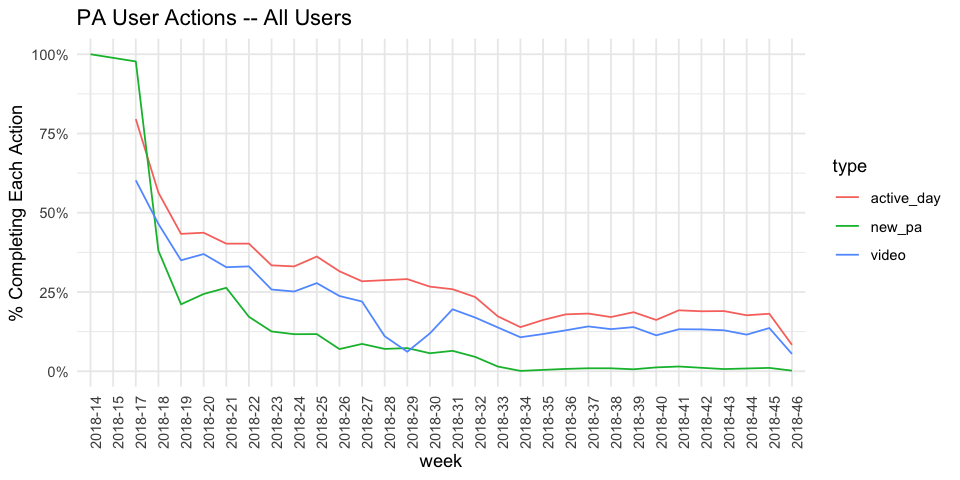

In [23]:
weekly_user_actions %>%
filter(type %in% free_metrics) %>%
ggplot(aes(x = week, y = perc_using, group = type)) + geom_line(aes(colour = type)) +
ggtitle("PA User Actions -- All Users") + theme_minimal() +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
scale_y_continuous(labels = scales::percent) + ylab("% Completing Each Action")


options(repr.plot.width=7, repr.plot.height=5)

## Who are our power users?

In [24]:
power_df <- clean_data %>%
    filter(type != 'new_pa') %>%
    group_by(user_id, type, date) %>%
    summarise(n = n()) %>%
    mutate(n = ifelse(n > 1 & type == 'active_day', 1, n)) %>%
    group_by(user_id, type) %>%
    summarise(total = sum(n)) %>%
    arrange(desc(total)) %>%
    left_join(customer_data)

Joining, by = "user_id"


In [25]:
head(power_df, 10)

user_id type        total first_name last_name nickname    degree
1  203068  flashcard   772   Logoi      Davis     NA          NA    
2  174617  flashcard   429   Deborah    King      NA          NA    
3  181438  video       266   Erik       Rush      Wingate     PA    
4  187705  flashcard   264   Braedon    Haertling Kentucky PA PA    
5  181563  video       261   Clay       Walker    SIUMED      MD    
6  174472  video       252   Jonathan   Clark     OU          PA    
7  179140  audio       251   Ben        Loschky   Cumberlands PA    
8  179140  note        245   Ben        Loschky   Cumberlands PA    
9  179140  whiteboards 243   Ben        Loschky   Cumberlands PA    
10 207163  video       230   Susie      Mao       Touro PA    PA    
   name        
1  professional
2  professional
3  student     
4  student     
5  professional
6  student     
7  student     
8  student     
9  student     
10 student

In [26]:
# Who has the most active days?
power_df %>%
    filter(type == 'active_day') %>%
    head(10)

user_id type       total first_name last_name    nickname      degree
1  174617  active_day 92    Deborah    King         NA            NA    
2  174472  active_day 91    Jonathan   Clark        OU            PA    
3  185521  active_day 89    Victoria   Eskay        GWU PA        PA    
4  186304  active_day 88    Doria      Cole         Rutgers PA    PA    
5  199655  active_day 84    Sarah      Beard        LSUHSC        PA    
6  187705  active_day 76    Braedon    Haertling    Kentucky PA   PA    
7  203305  active_day 70    Lorna      Ching-Carter Duke PA       PA    
8  179811  active_day 68    Brock      Golembieski  GVSU          PA    
9  184225  active_day 68    PHILLIP    MARLOWE      South College PA    
10 185147  active_day 68    sandra     anton        Duke PA       PA    
   name        
1  professional
2  student     
3  student     
4  student     
5  student     
6  student     
7  professional
8  student     
9  student     
10 student

In [27]:
# Who has watched the most videos?
power_df %>%
    filter(type == "video") %>%
    head(10)

user_id type  total first_name last_name   nickname   degree name        
1  181438  video 266   Erik       Rush        Wingate    PA     student     
2  181563  video 261   Clay       Walker      SIUMED     MD     professional
3  174472  video 252   Jonathan   Clark       OU         PA     student     
4  207163  video 230   Susie      Mao         Touro PA   PA     student     
5  174617  video 221   Deborah    King        NA         NA     professional
6  177141  video 147   Serik      Tursunaliev NA         MD     student     
7  186304  video 137   Doria      Cole        Rutgers PA PA     student     
8  179230  video 135   Jenny      Lin         BU         PA     student     
9  185531  video 135   Emily      Lipsitz     UCWV       PA     student     
10 176412  video 134   Jordan     Trimarco    Butler     PA     student

In [28]:
# Who has done the most flashcards?
power_df %>%
    filter(type == "flashcard") %>%
    head(10)

user_id type      total first_name last_name    nickname      degree
1  203068  flashcard 772   Logoi      Davis        NA            NA    
2  174617  flashcard 429   Deborah    King         NA            NA    
3  187705  flashcard 264   Braedon    Haertling    Kentucky PA   PA    
4  217795  flashcard 196   Christine  Gutierrez    Keck PA       PA    
5  174785  flashcard 186   Matthew    Zamora       CMU PA        PA    
6  207978  flashcard 119   KIMBERLY   LUTU         NA            PA    
7  208803  flashcard  99   irene      Soloway      NA            NA    
8  179979  flashcard  93   adam       detig        South College PA    
9  228082  flashcard  83   Brad       Tolly        NA            NA    
10 203305  flashcard  65   Lorna      Ching-Carter Duke PA       PA    
   name        
1  professional
2  professional
3  student     
4  student     
5  professional
6  student     
7  professional
8  student     
9  professional
10 professional

In [29]:
power_df %>%
    group_by(type) %>%
    summarise(n = n())

type           n  
1  active_day     972
2  audio           43
3  bootcamp-video   8
4  case            32
5  category_audio  17
6  category_notes  64
7  flashcard      110
8  note           100
9  notes           23
10 time           262
11 video          851
12 whiteboards     27